In [23]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [24]:
def rastrigin(pos,dim):                        
    return 10 * dim + sum([(x**2 - 10 * np.cos(2 * np.pi * x)) for x in pos])


In [25]:
class Particle: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim

        self.fitness = rastrigin(self.position,dim)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = rastrigin(self.position,self.dim)
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level
        new_vel = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        self.velocity = new_vel
        return new_vel

In [26]:
class PSO: # all the material that is relavant at swarm leveel

    def __init__(self, w, a1, a2, dim, population_size, time_steps, search_range):

        # Here we use values that are (somewhat) known to be good
        # There are no "best" parameters (No Free Lunch), so try using different ones
        # There are several papers online which discuss various different tunings of a1 and a2
        # for different types of problems
        self.w = w # Inertia
        self.a1 = a1 # Attraction to personal best
        self.a2 = a2 # Attraction to global best
        self.dim = dim

        self.swarm = [Particle(dim,-search_range,search_range) for i in range(population_size)]
        self.time_steps = time_steps

        # Initialising global best, you can wait until the end of the first time step
        # but creating a random initial best and fitness which is very high will mean you
        # do not have to write an if statement for the one off case
        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e100

    def run(self):
        for t in range(self.time_steps):
            p = t%len(self.swarm)
            particle = self.swarm[p]

            new_position = particle.position + particle.updateVel(self.w, self.a1, self.a2, particle.best_particle_pos, self.best_swarm_pos)
                            
            if new_position@new_position > 1.0e+18: # The search will be terminated if the distance 
                                                    # of any particle from center is too large
                print('Time:', t,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                raise SystemExit('Most likely divergent: Decrease parameter values')

            self.swarm[p].setPos(new_position)

            new_fitness = rastrigin(new_position,self.dim)

            if new_fitness < self.best_swarm_fitness:   # to update the global best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new group norm) are needed
                self.best_swarm_fitness = new_fitness
                self.best_swarm_pos = new_position
                if self.best_swarm_fitness <= 1.0e-6: return t;
            
        return self.time_steps


                    

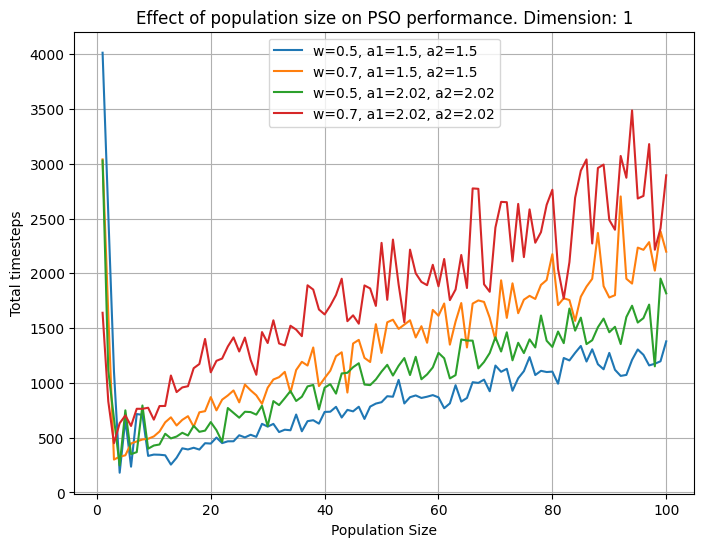

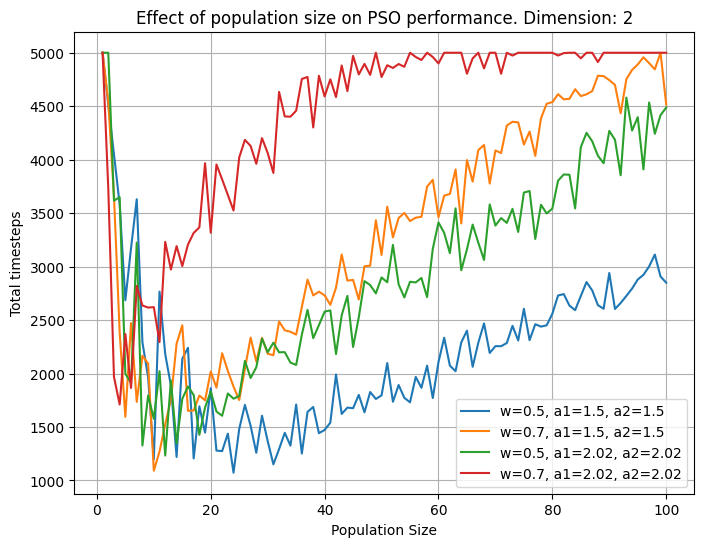

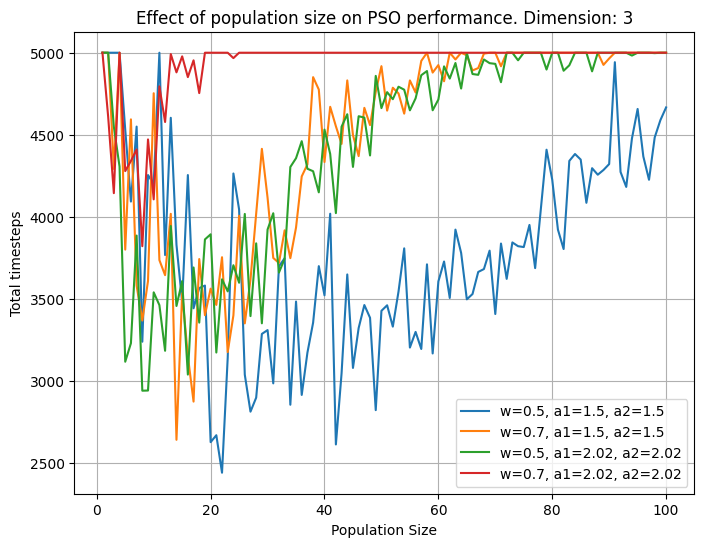

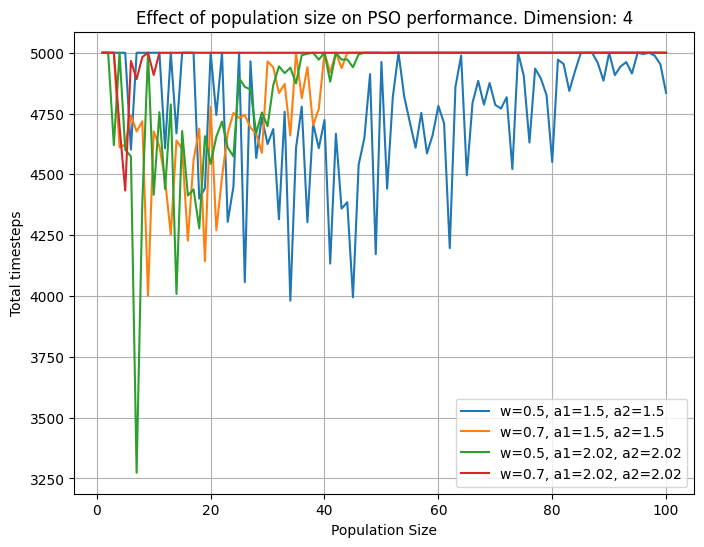

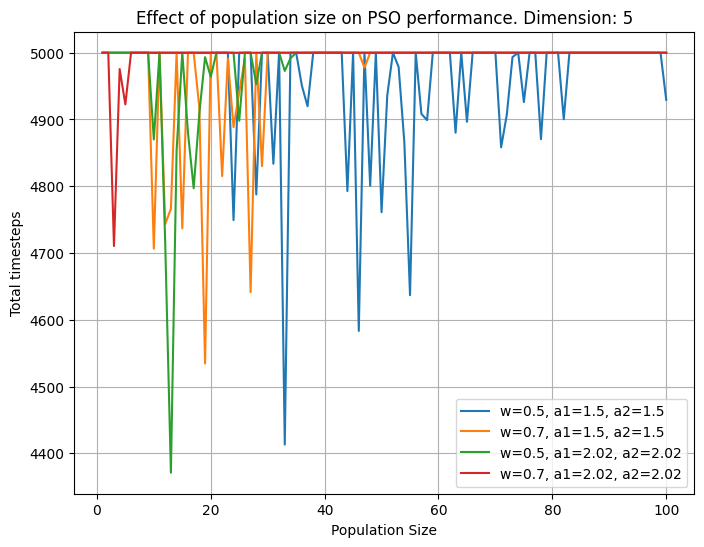

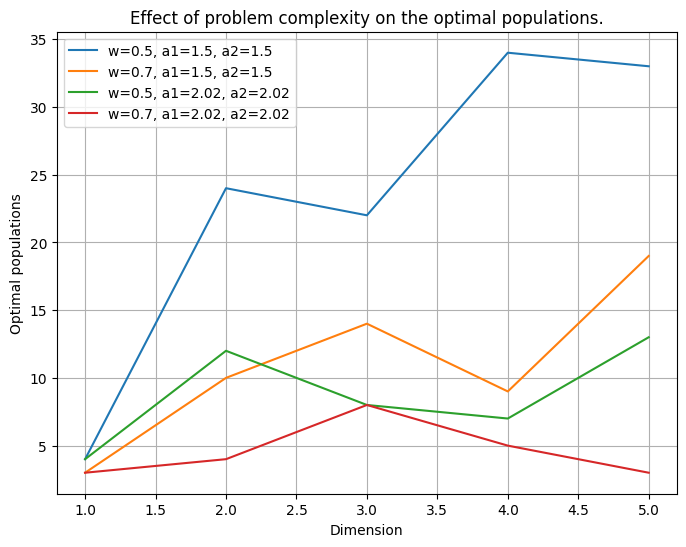

In [27]:
# Constants definition
POPULATION_SIZE = 100
DIMENSIONS = 5
TIME_STEPS = 5000
SAMPLE_ITERATIONS = 10

optimal_populations_per_dimensions1 = []
optimal_populations_per_dimensions2 = []
optimal_populations_per_dimensions3 = []
optimal_populations_per_dimensions4 = []

for d in range(DIMENSIONS): 
    avg_timesteps1 = []
    avg_timesteps2 = []
    avg_timesteps3 = []
    avg_timesteps4 = []
    for pop_size in range(POPULATION_SIZE):
        sum_timesteps1 = 0
        sum_timesteps2 = 0
        sum_timesteps3 = 0
        sum_timesteps4 = 0
        for it in range(SAMPLE_ITERATIONS):
            pso_instance1 = PSO(dim=d+1, w=0.5, a1=1.5, a2=1.5, population_size=pop_size+1, time_steps=TIME_STEPS, search_range=5.12)
            pso_instance2 = PSO(dim=d+1, w=0.7, a1=1.5, a2=1.5, population_size=pop_size+1, time_steps=TIME_STEPS, search_range=5.12)
            pso_instance3 = PSO(dim=d+1, w=0.5, a1=2.02, a2=2.02, population_size=pop_size+1, time_steps=TIME_STEPS, search_range=5.12)
            pso_instance4 = PSO(dim=d+1, w=0.7, a1=2.02, a2=2.02, population_size=pop_size+1, time_steps=TIME_STEPS, search_range=5.12)
            total_timesteps1 = pso_instance1.run()
            total_timesteps2 = pso_instance2.run()
            total_timesteps3 = pso_instance3.run()
            total_timesteps4 = pso_instance4.run()
            sum_timesteps1 += total_timesteps1
            sum_timesteps2 += total_timesteps2
            sum_timesteps3 += total_timesteps3
            sum_timesteps4 += total_timesteps4
        avg_timesteps1.append(sum_timesteps1/SAMPLE_ITERATIONS)
        avg_timesteps2.append(sum_timesteps2/SAMPLE_ITERATIONS)
        avg_timesteps3.append(sum_timesteps3/SAMPLE_ITERATIONS)
        avg_timesteps4.append(sum_timesteps4/SAMPLE_ITERATIONS)
            
    optimal_populations_per_dimensions1.append(np.argmin(avg_timesteps1)+1)
    optimal_populations_per_dimensions2.append(np.argmin(avg_timesteps2)+1)
    optimal_populations_per_dimensions3.append(np.argmin(avg_timesteps3)+1)
    optimal_populations_per_dimensions4.append(np.argmin(avg_timesteps4)+1)

    # Plotting the results
    plt.figure(figsize=(8, 6))
    plt.plot(range(1,POPULATION_SIZE+1), avg_timesteps1, label="w=0.5, a1=1.5, a2=1.5")
    plt.plot(range(1,POPULATION_SIZE+1), avg_timesteps2, label="w=0.7, a1=1.5, a2=1.5")
    plt.plot(range(1,POPULATION_SIZE+1), avg_timesteps3, label="w=0.5, a1=2.02, a2=2.02")
    plt.plot(range(1,POPULATION_SIZE+1), avg_timesteps4, label="w=0.7, a1=2.02, a2=2.02")
    plt.title(f'Effect of population size on PSO performance. Dimension: {d+1}')
    plt.xlabel('Population Size')
    plt.ylabel('Total timesteps')
    plt.grid(True)
    plt.legend()
    plt.show()


# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(range(1,DIMENSIONS+1), optimal_populations_per_dimensions1, label="w=0.5, a1=1.5, a2=1.5")
plt.plot(range(1,DIMENSIONS+1), optimal_populations_per_dimensions2, label="w=0.7, a1=1.5, a2=1.5")
plt.plot(range(1,DIMENSIONS+1), optimal_populations_per_dimensions3, label="w=0.5, a1=2.02, a2=2.02")
plt.plot(range(1,DIMENSIONS+1), optimal_populations_per_dimensions4, label="w=0.7, a1=2.02, a2=2.02")

plt.title('Effect of problem complexity on the optimal populations.') 
plt.xlabel('Dimension')
plt.ylabel('Optimal populations')
plt.grid(True)
plt.legend()
plt.show()
